In [1]:
import spimage
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

## Choose a run

In [2]:
run = 14

In [3]:
path_to_sizing = "/Users/benedikt/data/LCLS/amol3416/sucrose/"

In [4]:
sizing_fname = path_to_sizing + "amol3416_r%04d_sizing.h5" %run

## Read in sizing/fluence results

In [5]:
index = 8

In [6]:
with h5py.File(sizing_fname, 'r') as f:
    image = f['entry_1/detector/thumbnail'][index,:,:].astype(np.float64)
    photons_r = f['entry_1/detector/photons_r'][index,:]
    photons_qr = f['entry_1/detector/photons_qr'][index,:]
    intensity = f['entry_1/sizing/intensity'][:][index]
    diameter = f['entry_1/sizing/diameter'][:][index]
    cx = f['entry_1/sizing/offcenterx'][:][index]
    cy = f['entry_1/sizing/offcentery'][:][index]
    wavelength = f['entry_1/experiment/wavelength'][:][index]
    material = str(np.array(f['entry_1/experiment/material'][...], dtype=str))
    background = f['entry_1/sizing/background'][:][index]
    distance = f['entry_1/detector/distance'][...]
    downsampling = f['entry_1/preproc/downsampling'][...]
    pixelsize  = f['entry_1/detector/pixelsize'][...] * downsampling
    mask_init = f['entry_1/detector/mask'][:]

## Downsampled mask

In [7]:
# Spherical mask
def rmask(r, sh, cx, cy):
    ny, nx = sh
    xx,yy = np.meshgrid(np.arange(nx), np.arange(ny))
    return (xx-cx)**2 + (yy-cy)**2 > (r**2)

In [8]:
_, mask_ds = spimage.binImage(np.ones(mask_init.shape), downsampling, 
                                    msk=mask_init, output_binned_mask=True)
mask = mask_ds.astype(np.bool)
mask &= rmask(105/downsampling, mask.shape, mask.shape[1]//2+int(cx), mask.shape[0]//2+int(cy))

## Calculate fitted image/radial average

In [9]:
Y,X = spimage.grid(image.shape, (0,0))
Xc = spimage.x_to_qx(X - cx,pixelsize,distance)
Yc = spimage.y_to_qy(Y - cy,pixelsize,distance)
q = np.sqrt(Xc**2 + Yc**2)
qr = spimage.x_to_qx(photons_qr, pixelsize/downsampling, distance)[:image.shape[0]//2]

In [10]:
def modelparams(I,d):
    A = spimage.sphere_model_convert_intensity_to_scaling(I, d, wavelength, 
                                                          pixelsize, distance, material=material)
    s = spimage.sphere_model_convert_diameter_to_size(d, wavelength, pixelsize, distance)
    return A,s

In [11]:
def model2d(I,d):
    A,s = modelparams(I,d)
    return np.random.poisson(spimage.I_sphere_diffraction(A,q,s)).astype(np.float64)

In [12]:
def model1d(I,d,qr):
    A,s = modelparams(I,d)
    return spimage.I_sphere_diffraction(A,qr,s)

##  Plotting the fitted results

In [13]:
cmap = cm.get_cmap('magma')
cmap.set_bad('green')
cmap.set_under('black')

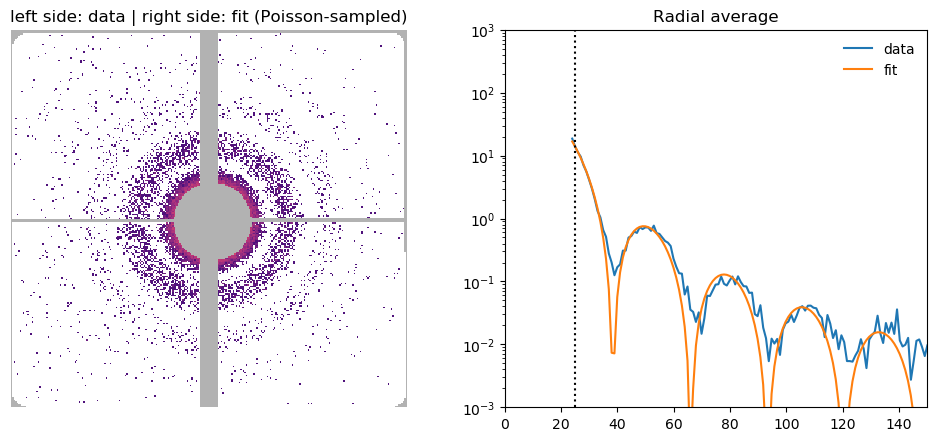

In [14]:
img = np.copy(image)
img[:,image.shape[1]//2:] = model2d(intensity,diameter)[:,image.shape[1]//2:]
img[img == 0] = 1e-10
img[~mask] = np.nan
cmap.set_bad('0.7')
cmap.set_under('white')
fig, axes = plt.subplots(ncols=2, figsize=(12,5), dpi=100)
axes[0].axis('off')
axes[0].set_title('left side: data | right side: fit (Poisson-sampled)')
axes[0].imshow(img*mask, norm=colors.LogNorm(vmin=0.1, vmax=1000), cmap=cmap)
axes[1].set_title("Radial average")
axes[1].plot(photons_qr, photons_r, label='data')
axes[1].plot(qr, model1d(intensity,diameter,qr), label='fit')
axes[1].set_ylim(1e-3,1e3)
axes[1].set_xlim(0,qr.max())
axes[1].axvline(25, ls=':', color='k')
axes[1].semilogy()
axes[1].legend(frameon=False)
plt.show()

## Create confidence map

In [15]:
def confidence(modelfunc, datay, datax, diameter, intensity, 
               dmax=10e-9, imax=50, N=100, plevel=0.95):
    drange = np.linspace(diameter-dmax, diameter+dmax,N)
    irange = np.linspace(intensity*(1-imax/100.), intensity*(1+imax/100.),N)
    dd,ii = np.meshgrid(drange,irange)
    chisquared = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            fit = modelfunc(ii[j,i],dd[j,i],datax)
            chisquared[j,i] = np.sum((fit-datay)**2)
    confmap = np.exp(-chisquared + chisquared.min())
    prob = (confmap/confmap.sum()).flatten()
    asort = np.argsort(prob)[::-1]
    confidence = prob[asort].cumsum() < plevel
    pmin = (prob[asort][confidence]*confmap.sum()).min()
    confmask = confmap > pmin 
    dlim = dd[confmask].min(), dd[confmask].max()
    ilim = ii[confmask].min(), ii[confmask].max()
    return confmap, dlim, ilim, drange, irange, pmin

In [16]:
data_r  = photons_r[:image.shape[0]//2]
data_qr = qr
mask_qr = data_qr > 25

In [17]:
C, dlim, ilim, drang, irang, clevel = confidence(model1d, data_r[mask_qr], data_qr[mask_qr], 
                                                 diameter, intensity)
derror = np.abs(diameter-dlim).max()/diameter
ierror = np.abs(intensity-ilim).max()/intensity
CXX, CYY = np.meshgrid(drang*1e9, (irang-intensity)/intensity*100)

## Plotting confidence map with lower/upper bounds

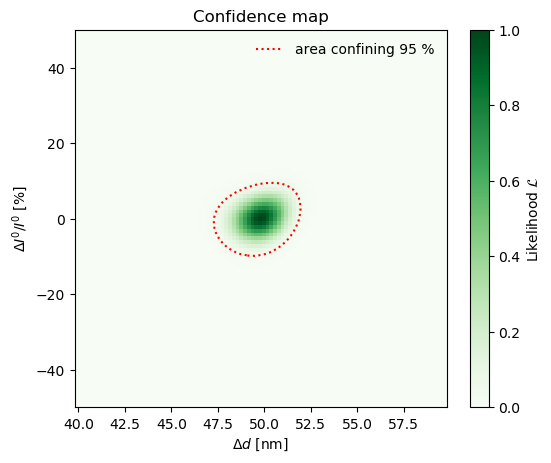

In [18]:
plt.figure(figsize=(6,5), dpi=100)
plt.title("Confidence map")
im = plt.pcolor(CXX,CYY,C,cmap='Greens')
ctr = plt.contour(CXX,CYY,C,levels=[clevel], colors=['red'], linestyles=[':'], lw=[0.5])
plt.xlabel(r'$\Delta d$ $[\mathrm{nm}]$')
plt.ylabel(r'$\Delta I^0/I^0$ $[\%]$')
plt.colorbar(im, label='Likelihood $\mathcal{L}$')
plt.legend(ctr.legend_elements()[0], ['area confining 95 %'], frameon=0)
plt.show()

## Estimated diameter and bounds

In [19]:
print("Estimated diameter: \t%.2f nm" %(diameter*1e9))
print("Diameter bounds: \t%.2f nm (lower)  \t%.2f nm (upper)" %(dlim[0]*1e9,
                                                                dlim[1]*1e9))

Estimated diameter: 	49.80 nm
Diameter bounds: 	47.47 nm (lower)  	51.92 nm (upper)


## Estimated fluence and bounds

In [20]:
print("Estimated fluence: \t%.2f uJ/um2" %(intensity*1e3/(1e-3/1e-12)))
print("Fluence bounds: \t%.2f uJ/um2 (lower)  \t%.2f uJ/um2 (upper)" %(ilim[0]*1e3/(1e-3/1e-12),
                                                                      ilim[1]*1e3/(1e-3/1e-12)))
print("Fluence bounds: \t%d%% (lower)  \t\t%d%% (upper)" %((ilim[0]-intensity)/intensity*100,
                                                           (ilim[1]-intensity)/intensity*100))

Estimated fluence: 	3.05 uJ/um2
Fluence bounds: 	2.76 uJ/um2 (lower)  	3.32 uJ/um2 (upper)
Fluence bounds: 	-9% (lower)  		8% (upper)
